# Graph analysis for a legislature

## Config

In [11]:
import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.lines as mlines
from itertools import combinations


### Load the JSON files and create the graph

In [12]:
def load_data(deputies_path, votes_path):
    with open(deputies_path, 'r', encoding='utf-8') as f:
        deputies = json.load(f)
    with open(votes_path, 'r', encoding='utf-8') as f:
        votes = json.load(f)
    return {"deputies": deputies, "votes": votes}

In [13]:
def create_graph(deputies, votes):
    G = nx.Graph()
    for deputy_id, deputy_info in deputies.items():
        G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
    co_votes = {}
    deputy_votes = {}
    
    for vote_id, vote_data in votes.items():
        pour_voters = vote_data['votes_for']
        all_voters = set(pour_voters + vote_data['votes_against'] + vote_data['votes_abs'])
        
        for deputy in all_voters:
            if deputy not in deputy_votes:
                deputy_votes[deputy] = set()
            deputy_votes[deputy].add(vote_id)
        
        for i in range(len(pour_voters)):
            for j in range(len(pour_voters)):
                if i != j:
                    deputy1 = pour_voters[i]
                    deputy2 = pour_voters[j]
                    if G.has_node(deputy1) and G.has_node(deputy2):
                        pair = tuple(sorted([deputy1, deputy2]))
                        co_votes[pair] = co_votes.get(pair, 0) + 0.5 

    for (deputy1, deputy2), pour_count in co_votes.items():
        common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
        total_common = len(common_votes)
        if total_common > 0:
            percentage = pour_count / total_common
            G.add_edge(deputy1, deputy2, weight=percentage)
            
    return G

In [14]:
def print_stats(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        print(f"Graph has {nx.number_connected_components(G)} connected components")

def get_giant_component(G):
    gcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(gcc_nodes).copy()

In [15]:
def plot_network(G, deputies):
    nodes_color = [deputies[node].get('organ',{}).get('color','#cccccc') for node in G.nodes()]
    party_colors = {deputies[node].get('organ',{}).get('color','#cccccc'):deputies[node].get('organ',{}).get('name','No name') for node in G.nodes()}
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=500, iterations=50, weight='weight', seed=42)
    nx.draw(G, pos, node_size=100, node_color=nodes_color, edge_color='lightgray', alpha=0.7, with_labels=False, width=edge_weights)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=name, markerfacecolor=color, markersize=10) for color, name in party_colors.items()], title="Political Parties", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Deputy Voting Network")
    plt.tight_layout()
    plt.show()

In [16]:
def plot_degree_distribution(G):
    degrees = dict(G.degree(weight='weight'))
    degree_values = list(degrees.values())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    degree_counts = Counter(degree_values)
    ks = sorted(degree_counts.keys())
    counts = [degree_counts[k] for k in ks]
    axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [17]:
def detect_communities(G):
    communities_set = nx.community.louvain_communities(G, weight="weight")
    num_communities = len(communities_set)
    partition = {}
    for community_id, nodes in enumerate(communities_set):
        for node in nodes:
            partition[node] = community_id
    
    cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
    nodes_color_com = [cmap(partition[node]) for node in G.nodes()]
    
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=500, iterations=50, weight= 'weight', seed=42)
    nx.draw(G, 
            pos, 
            node_size=100, node_color=nodes_color_com, 
            edge_color='lightgray',
            alpha=0.7, with_labels=False, width=0.1)
    plt.legend(handles=legend_handles,
            title="Computed communities", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Deputy Voting Network - Computed louvain communities (louvain)")
    plt.tight_layout()
    plt.show()

    print(f'Number of communies : {len(communities_set)}')
    modularity_score = nx.community.modularity(G, communities_set, weight='weight')
    print(f"Modularity score : {modularity_score}")
    return communities_set, modularity_score

In [18]:
def get_party_info(deputies):
    organ_name_dict = {}
    partis_members = {}
    for dep_id, data in deputies.items():
        if data['organ']:
            organ_id = data['organ']['id']
            organ_name_dict[organ_id] = (data['organ']['name'], data['organ']['name_short'])
            if organ_id not in partis_members:
                partis_members[organ_id] = []
            partis_members[organ_id].append(dep_id)
    return organ_name_dict, partis_members

In [19]:
def plot_community_matrix(partis_members, communities_set, organ_name_dict, all_member_ids):
    communities_dict = {f"C{i}": comm for i, comm in enumerate(communities_set)}
    community_tuples = []
    sorted_comm_keys = sorted(communities_dict.keys())
    for comm_key in sorted_comm_keys:
        comm_set = communities_dict[comm_key]
        members_in_comm = [item for item in comm_set if item in all_member_ids]
        community_tuples.append((comm_key, members_in_comm))
    
    party_member_lists = list(partis_members.values())
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(num_parti):
        party_i_members = party_member_lists[i]
        for j in range(num_commu):
            community_j_members = community_tuples[j][1]
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            num_party_members = len(party_i_members)
            if num_party_members > 0:
                D[i, j] *= 100 / num_party_members
            else:
                D[i, j] = 0

    x_labels = [f"{t[0]}\n(Size: {len(t[1])})" for t in community_tuples]
    y_labels = [organ_name_dict[g][1] for g in list(partis_members.keys())]
    
    plt.figure(figsize=(max(8, num_commu * 2.5), max(6, num_parti * 0.8)))
    sns.heatmap(D, annot=True, fmt='.0f', cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)
    plt.title('Normalized by Party Size (%)')
    plt.tight_layout()
    plt.show()

In [ ]:
    proximites_without_parties_parti = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties_parti[(i, j)] = weight

        proximites_debuties_parti = proximites_debuties
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_debuties_parti[(m1, m2)] = weight

In [51]:
def analyze_party_proximity(G, partis_members, organ_name_dict, deputies, plot):
    list_partis = list(partis_members.keys())
    proximites_partis = {}
    proximites_without_parties = {} # Between parties
    
    # Between parties
    for i in range(len(list_partis)-1):
        for j in range(i+1, len(list_partis)):
            proximites = []
            for member_i in partis_members[list_partis[i]]:
                for member_j in partis_members[list_partis[j]]:
                    if G.has_node(member_i) and G.has_node(member_j):
                        weigth = 0
                        if G.has_edge(member_i, member_j):
                            weigth = G[member_i][member_j]['weight']

                        proximites_without_parties[(member_i, member_j)] = weigth
                        proximites.append(weigth)
            if proximites:
                proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)

    # Total 
    proximites_debuties = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties[(i, j)] = weight

    # Within parties
    proximites_within_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_parties[(m1, m2)] = weight

    # Of parties
    proximites_of_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
        party_name = organ_name_dict.get(parti, (parti, parti))[1]
        proximites_of_parties[parti] = {"parti": parti, "name": party_name, "combinations": tmp}
        
    if plot:
        G_partis = nx.Graph()
        labels_dict = {}
        for parti_id, members in partis_members.items():
            nom_parti = organ_name_dict.get(parti_id, (parti_id, parti_id))[1]
            G_partis.add_node(parti_id, count=len(members), label_name=nom_parti)
            labels_dict[parti_id] = f"{nom_parti}\n({len(members)})"

        for (p1, p2), dist in proximites_partis.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_partis.add_edge(p1, p2, distance=dist, weight=1.0/safe_dist)

        node_colors = []
        for parti_id in G_partis.nodes():
            color = '#cccccc'
            members = partis_members.get(parti_id, [])
            if members and members[0] in deputies:
                color = deputies[members[0]].get('organ', {}).get('color', '#cccccc')
            node_colors.append(color)

        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G_partis, weight='weight', k=0.6, seed=42)
        nx.draw_networkx_nodes(G_partis, pos, node_size=[G_partis.nodes[n]['count'] * 50 for n in G_partis.nodes()], node_color=node_colors, alpha=0.9, edgecolors='white')
        nx.draw_networkx_labels(G_partis, pos, labels=labels_dict, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G_partis, pos, width=1, alpha=0.3, edge_color='gray')
        plt.axis('off')
        plt.show()
        
        parties_ids = list(G_partis.nodes())
        parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
        dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)
        for (p1, p2), dist in proximites_partis.items():
            if p1 in parties_ids and p2 in parties_ids:
                name1 = G_partis.nodes[p1]['label_name']
                name2 = G_partis.nodes[p2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist
                
        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis_r", linewidths=0.5)
        plt.title("Proximity matrix between parties")
        plt.show()

    print(len(proximites_partis), len(proximites_without_parties), len(proximites_debuties), len(proximites_within_parties), len(proximites_of_parties))

    return proximites_partis, proximites_without_parties, proximites_debuties, proximites_within_parties, proximites_of_parties

In [21]:
def calculate_party_modularity(G, partis_members):
    nodes_in_graph = set(G.nodes())
    cleaned_parti_com = []
    for members in partis_members.values():
        valid_members = [m for m in members if m in nodes_in_graph]
        if valid_members:
            cleaned_parti_com.append(valid_members)
    print(f"Modularity score - partis : {nx.community.modularity(G, cleaned_parti_com, weight='weight')}")

In [22]:
legislature_17 = load_data('data/processed/deputees_17.json', 'data/processed/vote_17.json')
legislature_16 = load_data('data/processed/deputees_16.json', 'data/processed/vote_16.json')
legislature_15 = load_data('data/processed/deputees_15.json', 'data/processed/vote_15.json')
legislature_14 = load_data('data/processed/deputees_14.json', 'data/processed/vote_14.json')

In [23]:
G_17 = get_giant_component(create_graph(legislature_17["deputies"], legislature_17["votes"]))
G_16 = get_giant_component(create_graph(legislature_16["deputies"], legislature_16["votes"]))
G_15 = get_giant_component(create_graph(legislature_15["deputies"], legislature_15["votes"]))
G_14 = get_giant_component(create_graph(legislature_14["deputies"], legislature_14["votes"]))

In [24]:
organ_name_dict_17, partis_members_17 = get_party_info(legislature_17["deputies"])
organ_name_dict_16, partis_members_16 = get_party_info(legislature_16["deputies"])
organ_name_dict_15, partis_members_15 = get_party_info(legislature_15["deputies"])
organ_name_dict_14, partis_members_14 = get_party_info(legislature_14["deputies"])

In [52]:
proximites_partis_17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17 = analyze_party_proximity(G_17, partis_members_17, organ_name_dict_17, legislature_17["deputies"], False)
proximites_partis_16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16 = analyze_party_proximity(G_16, partis_members_16, organ_name_dict_16, legislature_16["deputies"], False)
proximites_partis_15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15 = analyze_party_proximity(G_15, partis_members_15, organ_name_dict_15, legislature_15["deputies"], False)
proximites_partis_14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14 = analyze_party_proximity(G_14, partis_members_14, organ_name_dict_14, legislature_14["deputies"], False)

78 159635 181503 21868 12
55 153933 182710 28777 11
55 153933 182710 28777 11
78 154345 208981 54636 13
78 154345 208981 54636 13
36 136482 201295 64813 9
36 136482 201295 64813 9


In [59]:
def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def plot_proximity_comparison(prox_between, prox_total, prox_within, prox_of_parties, deputies, legislature_id):
    plt.figure(figsize=(14, 9))
    
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.1, color='grey', linestyle='--', linewidth=2)
    sns.kdeplot(list(prox_within.values()), label='Within Parties (All)', fill=True, alpha=0.1, color='black', linewidth=2)
    #sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.1)

    party_colors = {}
    for dep in deputies.values():
        if dep.get('organ'):
            party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

    for party_id, data in prox_of_parties.items():
        vals = list(data['combinations'].values())
        if len(vals) > 5: # Filter slightly to avoid KDE errors on very few points
            color = party_colors.get(party_id, '#cccccc')
            sns.kdeplot(vals, label=f"{data['name']}", color=color, linestyle=':', linewidth=3.5, alpha=0.9)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}', fontsize=16)
    plt.xlabel('Proximity (Weight)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

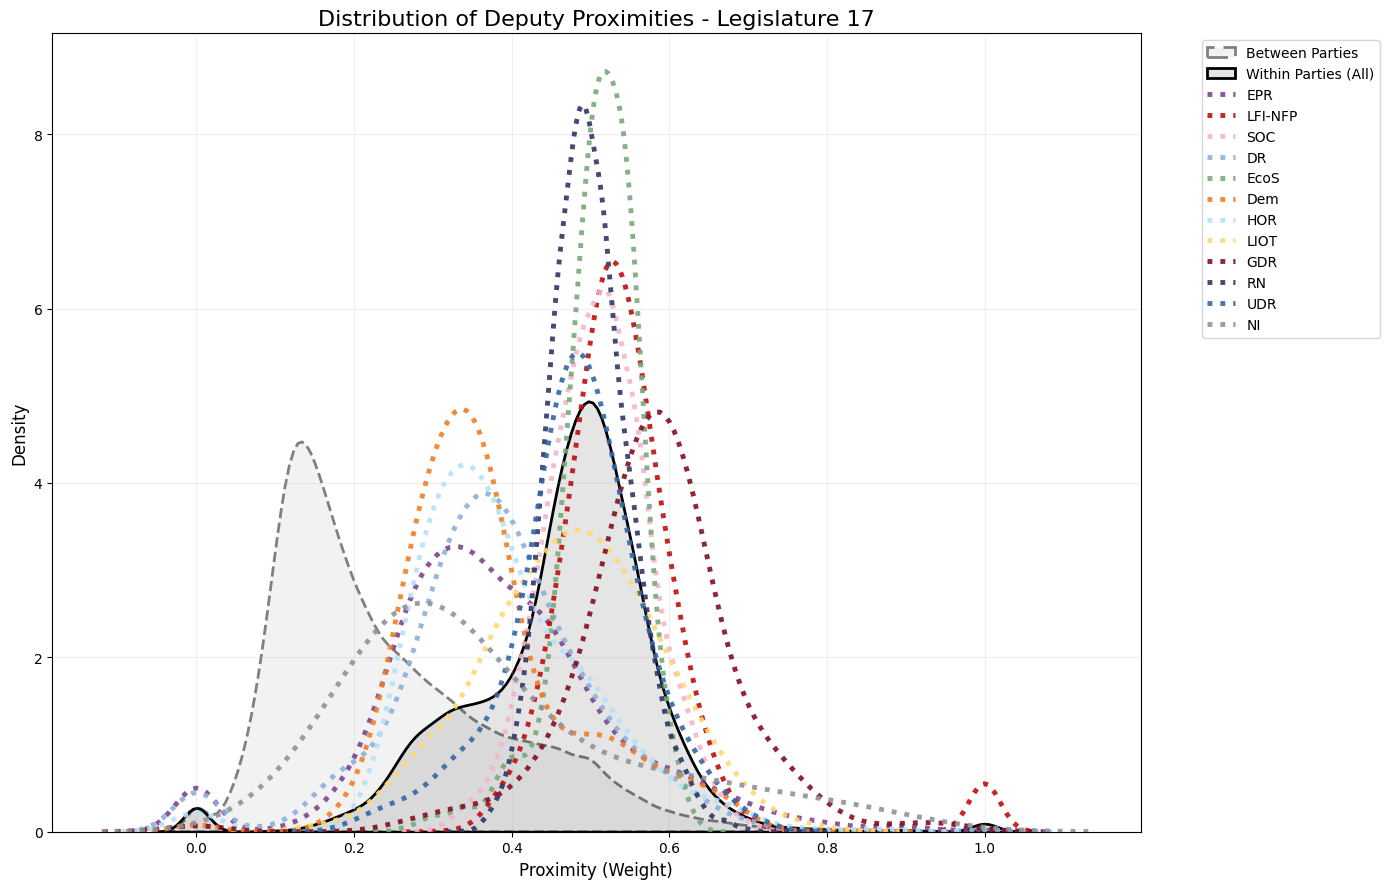

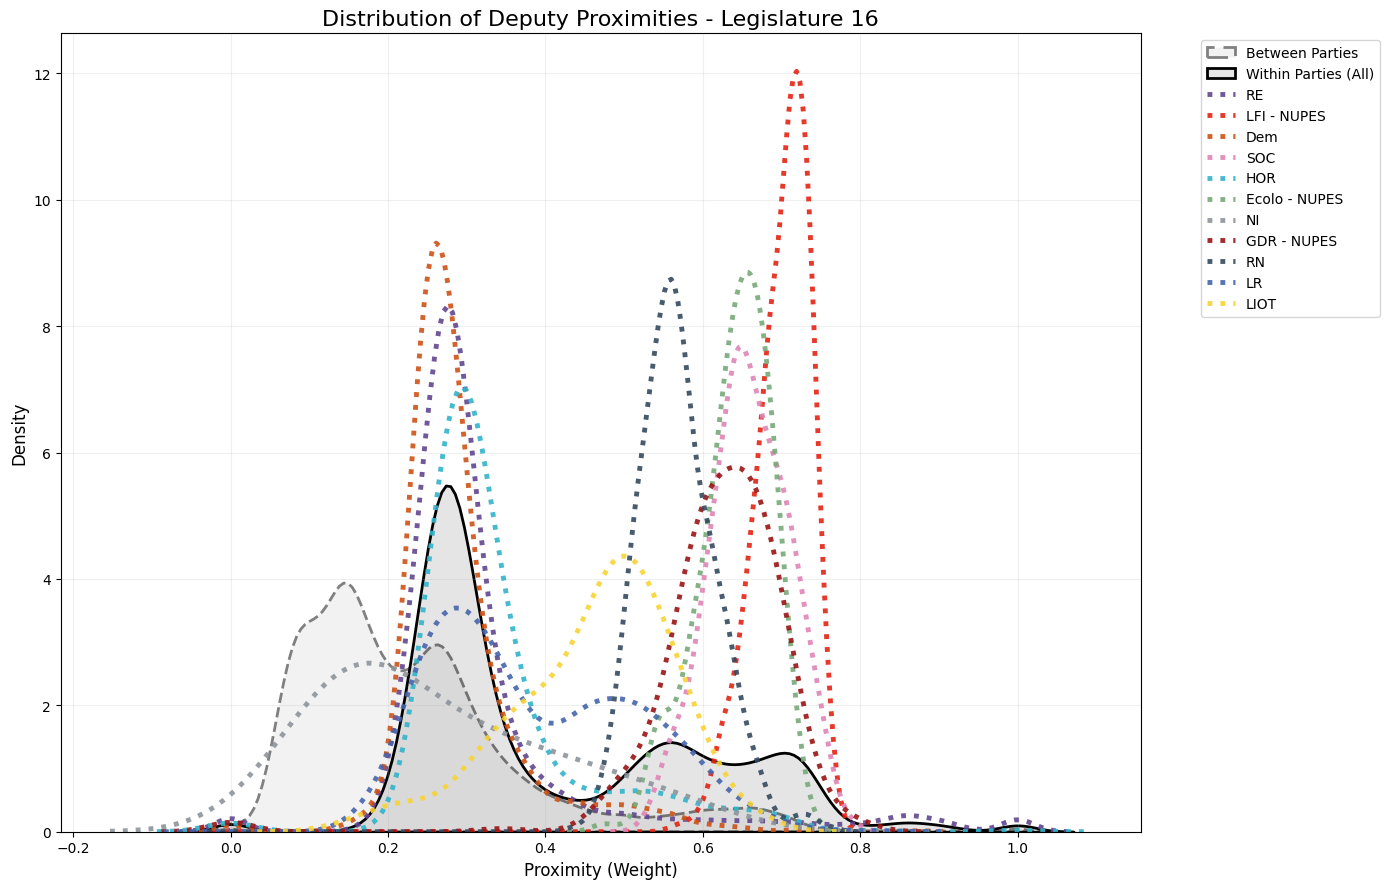

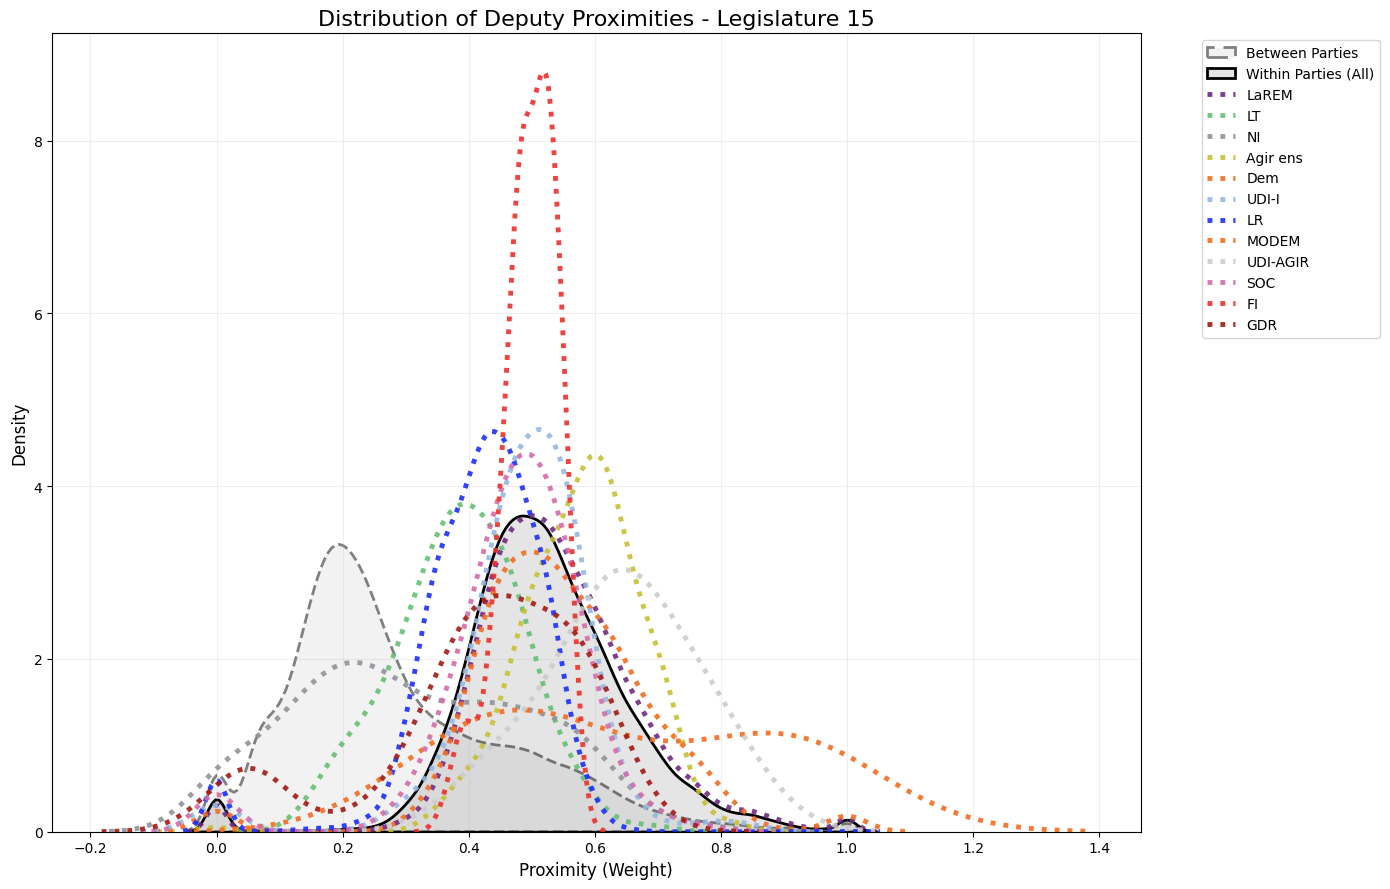

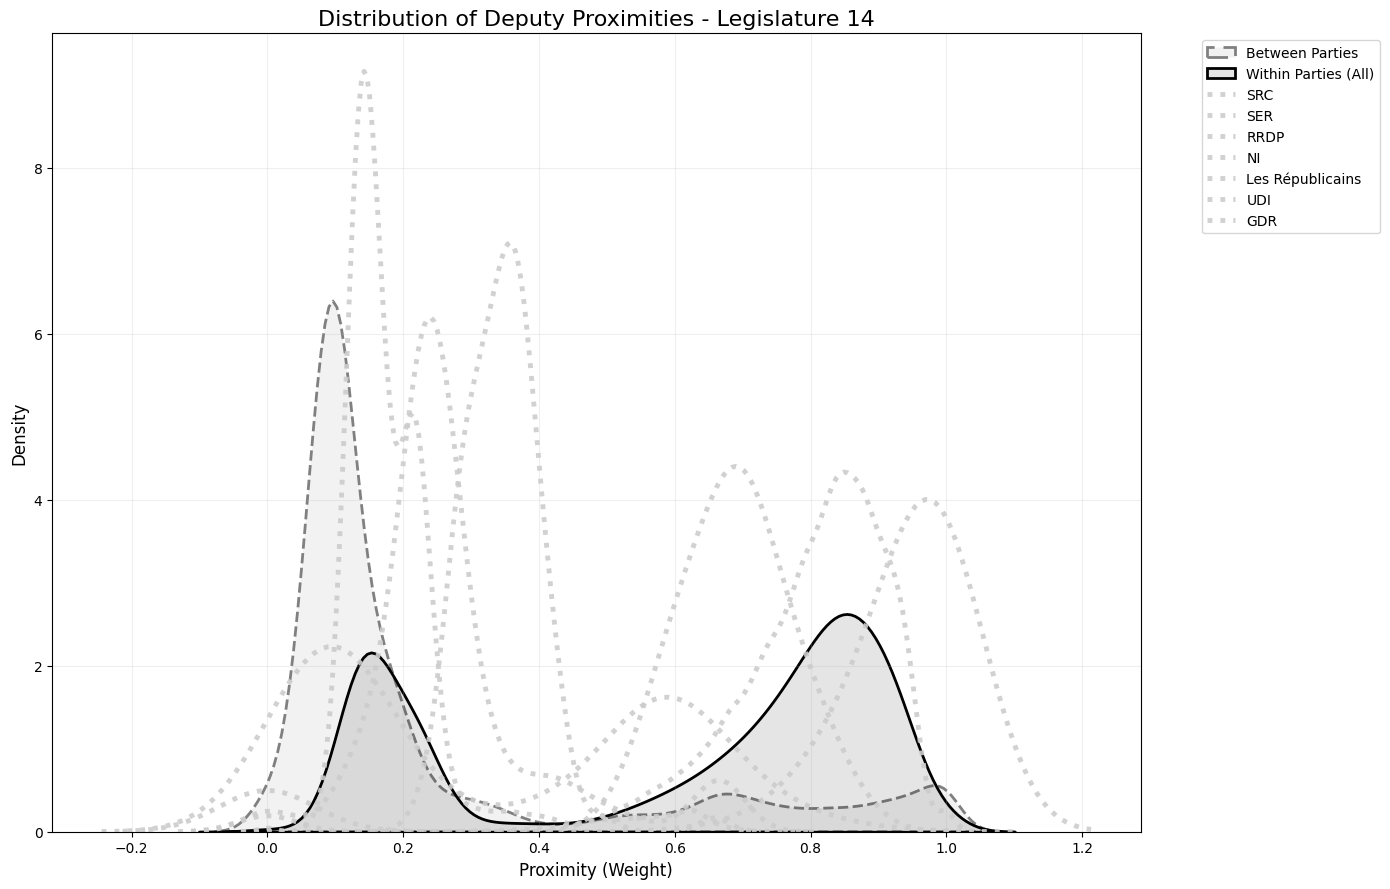

In [60]:
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)
plot_proximity_comparison(proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16, legislature_16["deputies"], 16)
plot_proximity_comparison(proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15, legislature_15["deputies"], 15)
plot_proximity_comparison(proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14, legislature_14["deputies"], 14)


C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


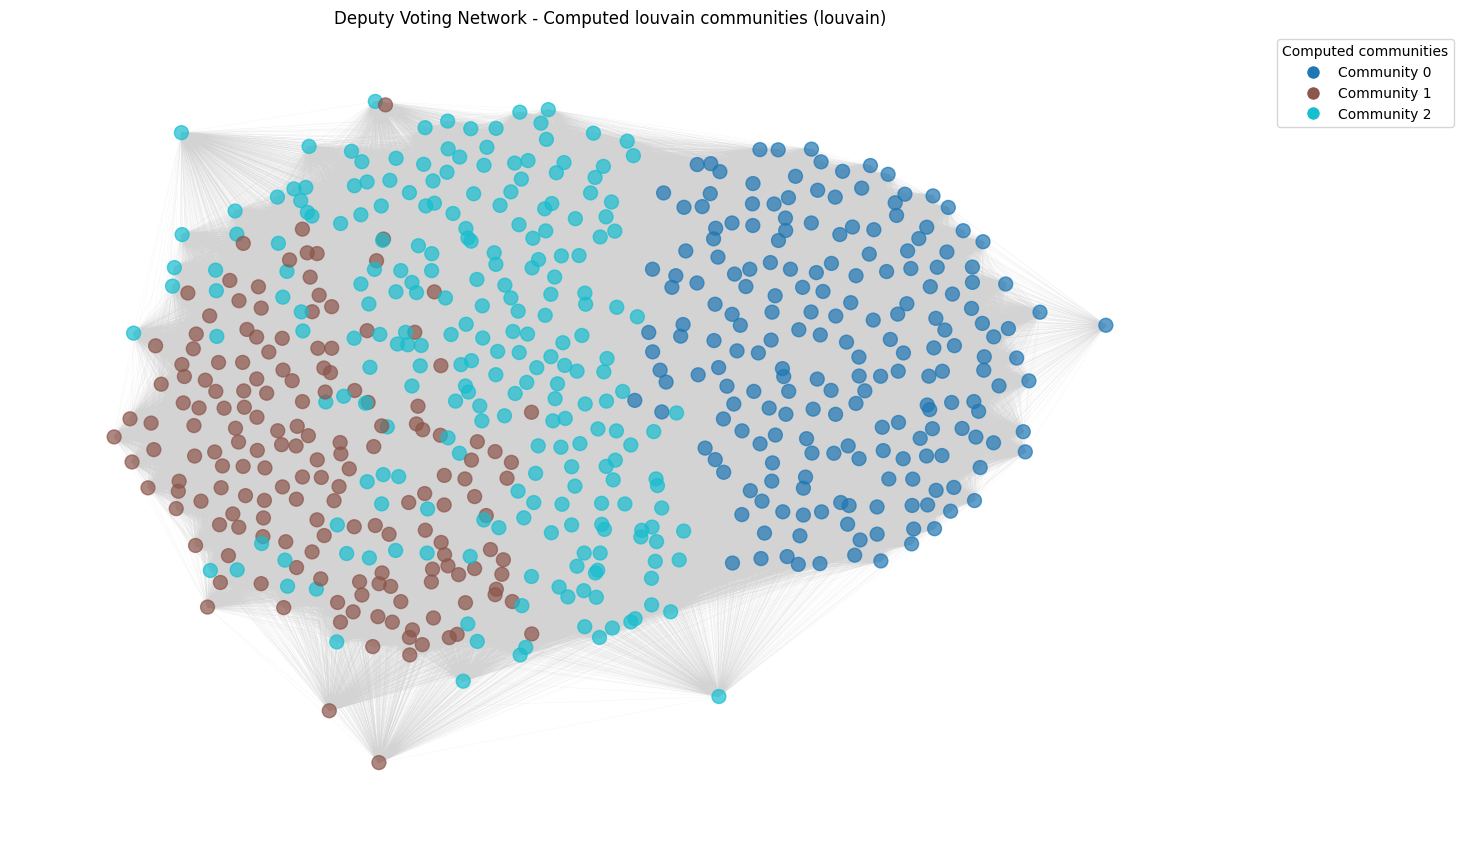

Number of communies : 3
Modularity score : 0.19481310466614432
Modularity score : 0.19481310466614432


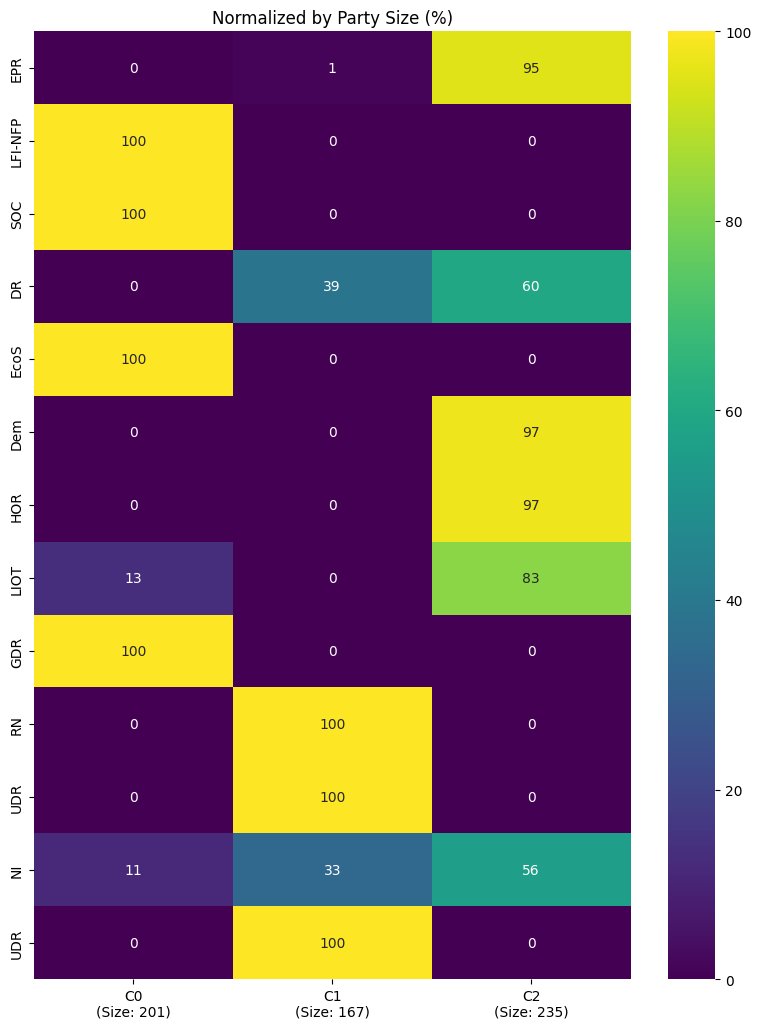

[{'PA1008',
  'PA1567',
  'PA1654',
  'PA267306',
  'PA2940',
  'PA331973',
  'PA333285',
  'PA335054',
  'PA335612',
  'PA335999',
  'PA340343',
  'PA341981',
  'PA342196',
  'PA342384',
  'PA342415',
  'PA588884',
  'PA605745',
  'PA606545',
  'PA606573',
  'PA606793',
  'PA607553',
  'PA607619',
  'PA608172',
  'PA608264',
  'PA609332',
  'PA610002',
  'PA610654',
  'PA610968',
  'PA642764',
  'PA643143',
  'PA643157',
  'PA643175',
  'PA643192',
  'PA719286',
  'PA719578',
  'PA719930',
  'PA720362',
  'PA720430',
  'PA720838',
  'PA720846',
  'PA720892',
  'PA720952',
  'PA720992',
  'PA721062',
  'PA721202',
  'PA721210',
  'PA721270',
  'PA721896',
  'PA721960',
  'PA722142',
  'PA722150',
  'PA736201',
  'PA774958',
  'PA774960',
  'PA774962',
  'PA791812',
  'PA791824',
  'PA793174',
  'PA793262',
  'PA793394',
  'PA793444',
  'PA793452',
  'PA793464',
  'PA793532',
  'PA793624',
  'PA793664',
  'PA793708',
  'PA793736',
  'PA793744',
  'PA793756',
  'PA793772',
  'PA793780',


In [ ]:
communities_set, modularity_score = detect_communities(G_17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


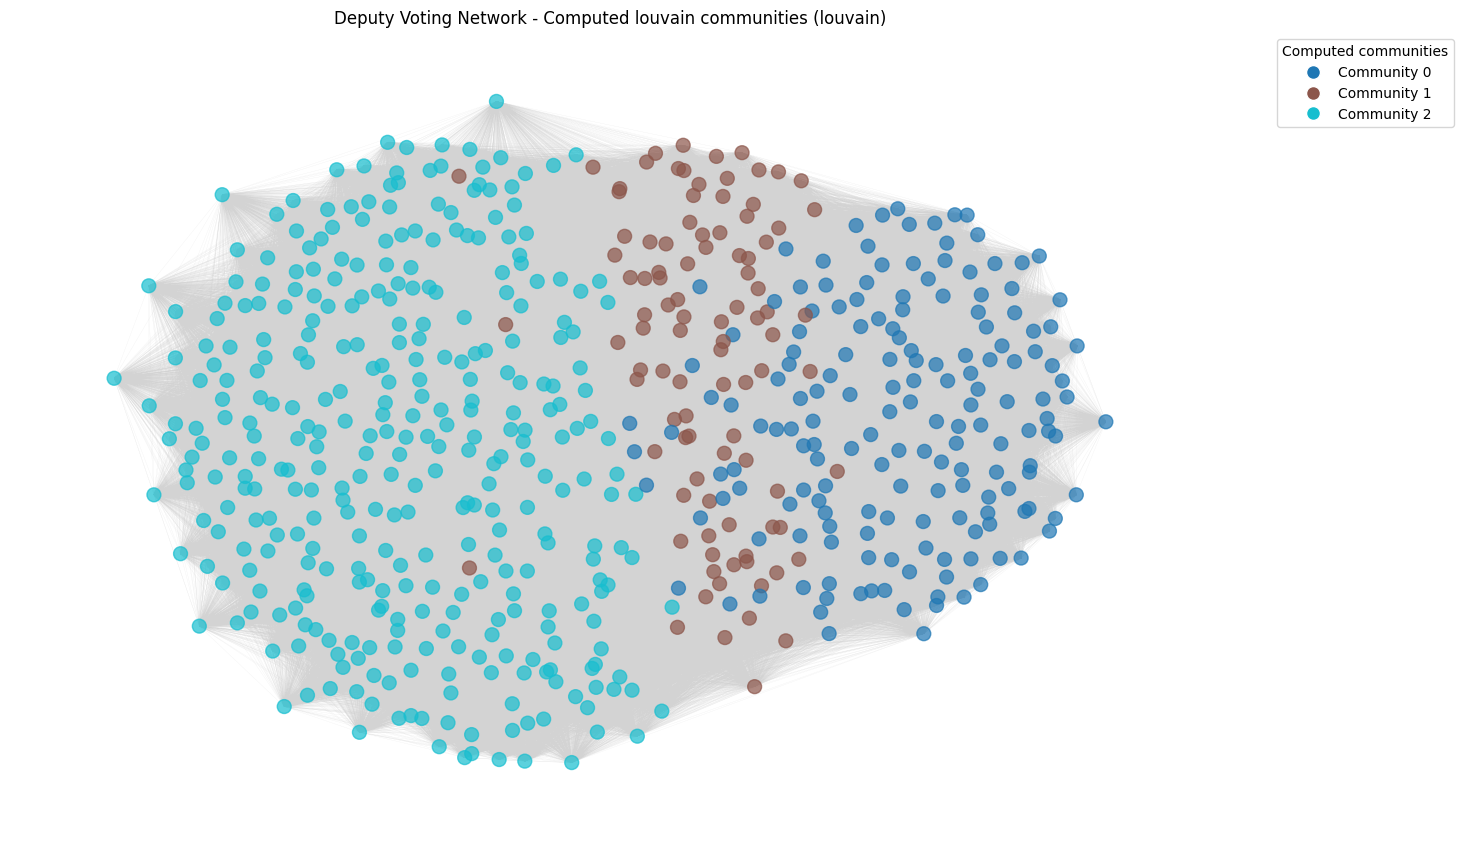

Number of communies : 3
Modularity score : 0.21062038391537935


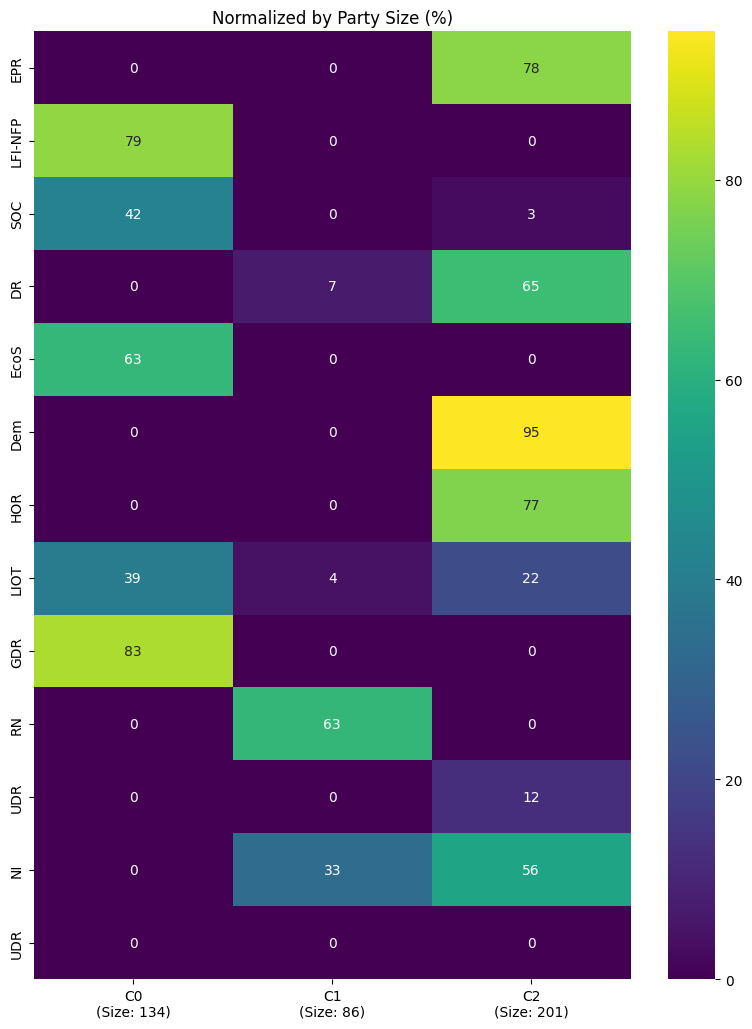

[{'PA1008',
  'PA1567',
  'PA267306',
  'PA333285',
  'PA335054',
  'PA335612',
  'PA335999',
  'PA340343',
  'PA342196',
  'PA342384',
  'PA342415',
  'PA344201',
  'PA588884',
  'PA605069',
  'PA605745',
  'PA607553',
  'PA607619',
  'PA608172',
  'PA608695',
  'PA609332',
  'PA609590',
  'PA610002',
  'PA610654',
  'PA642764',
  'PA643143',
  'PA643157',
  'PA643192',
  'PA718860',
  'PA718926',
  'PA719138',
  'PA719146',
  'PA719286',
  'PA719578',
  'PA719930',
  'PA720286',
  'PA720422',
  'PA720430',
  'PA720692',
  'PA720838',
  'PA720846',
  'PA720892',
  'PA720952',
  'PA720960',
  'PA720976',
  'PA720992',
  'PA721046',
  'PA721062',
  'PA721118',
  'PA721202',
  'PA721210',
  'PA721270',
  'PA721896',
  'PA721960',
  'PA722110',
  'PA722142',
  'PA722202',
  'PA722344',
  'PA736201',
  'PA774958',
  'PA774960',
  'PA774962',
  'PA791812',
  'PA791824',
  'PA793110',
  'PA793174',
  'PA793210',
  'PA793262',
  'PA793394',
  'PA793444',
  'PA793452',
  'PA793464',
  'PA79353

In [ ]:
communities_set, modularity_score = detect_communities(G_16)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


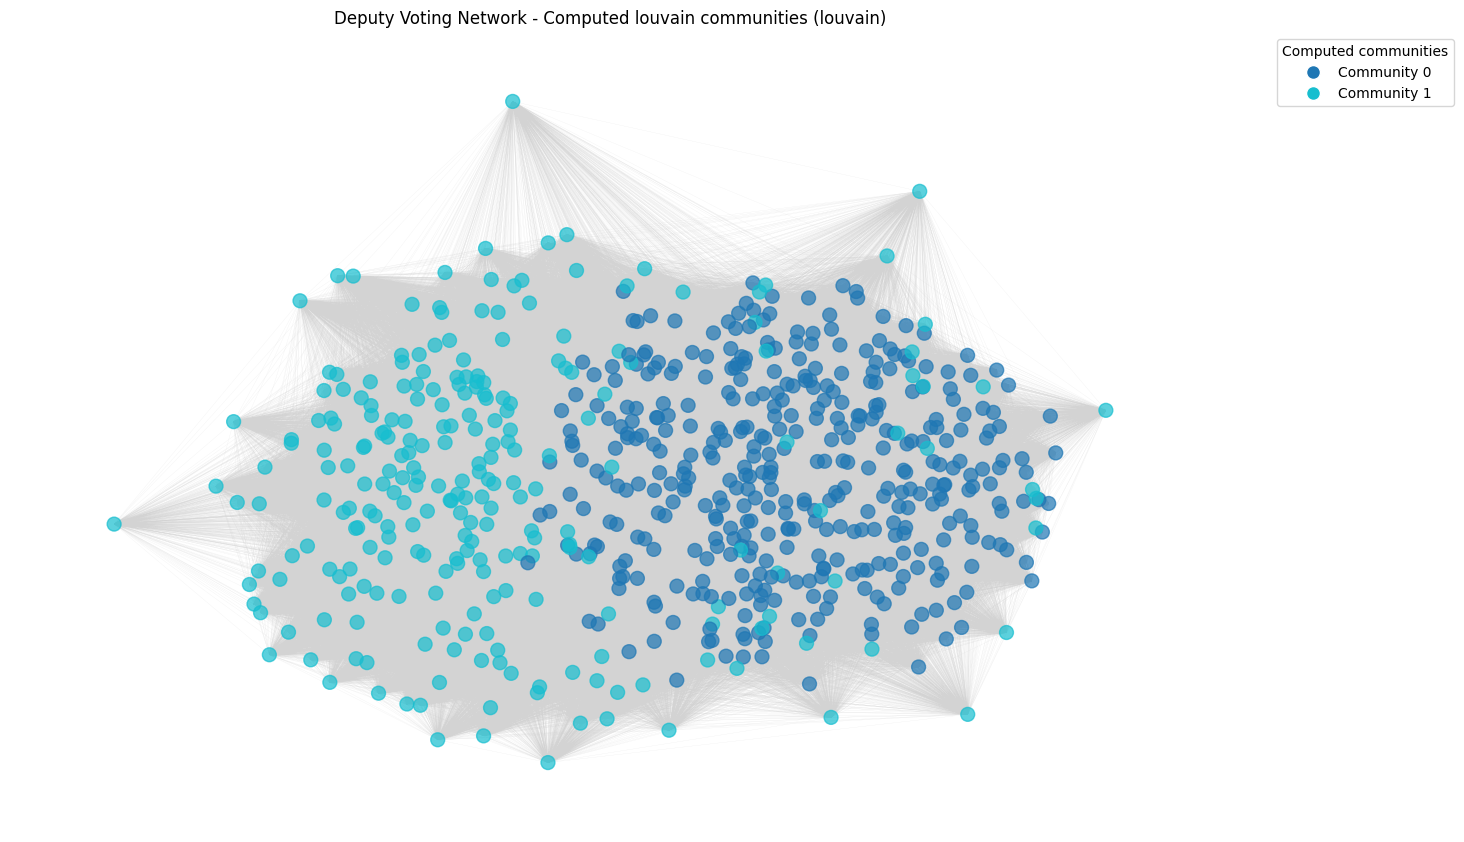

Number of communies : 2
Modularity score : 0.12463631146675501
Modularity score : 0.12463631146675501


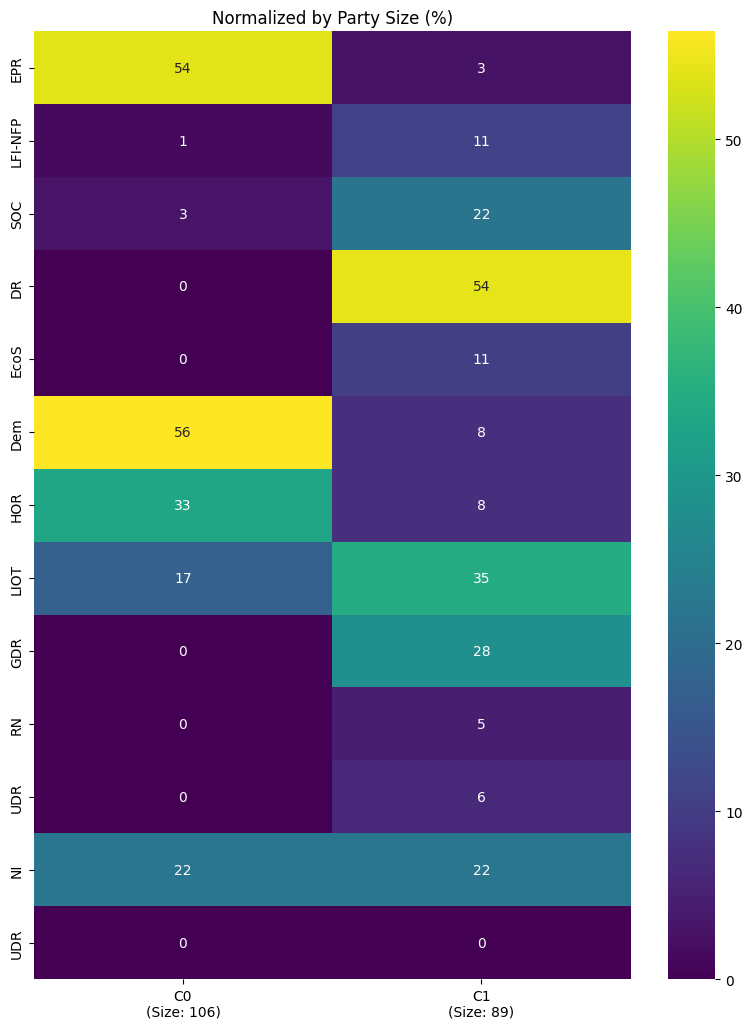

[{'PA1276',
  'PA1960',
  'PA2449',
  'PA267241',
  'PA267336',
  'PA267337',
  'PA267355',
  'PA267622',
  'PA267673',
  'PA267780',
  'PA267801',
  'PA2828',
  'PA2952',
  'PA331567',
  'PA331835',
  'PA332747',
  'PA334116',
  'PA334768',
  'PA335758',
  'PA343493',
  'PA346876',
  'PA605084',
  'PA605131',
  'PA605963',
  'PA606171',
  'PA606202',
  'PA606507',
  'PA606639',
  'PA606675',
  'PA607155',
  'PA607193',
  'PA607395',
  'PA607595',
  'PA608083',
  'PA608641',
  'PA609520',
  'PA610733',
  'PA610775',
  'PA642695',
  'PA642724',
  'PA642788',
  'PA642935',
  'PA643127',
  'PA643175',
  'PA643205',
  'PA672',
  'PA677483',
  'PA693008',
  'PA702054',
  'PA712014',
  'PA717151',
  'PA717167',
  'PA717379',
  'PA718674',
  'PA718682',
  'PA718694',
  'PA718706',
  'PA718710',
  'PA718728',
  'PA718736',
  'PA718756',
  'PA718768',
  'PA718794',
  'PA718802',
  'PA718810',
  'PA718876',
  'PA718894',
  'PA718902',
  'PA718910',
  'PA718918',
  'PA718930',
  'PA718944',
  'PA

In [ ]:
communities_set, modularity_score = detect_communities(G_15)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\ajkfh\AppData\Local\Temp\ipykernel_37536\241350631.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


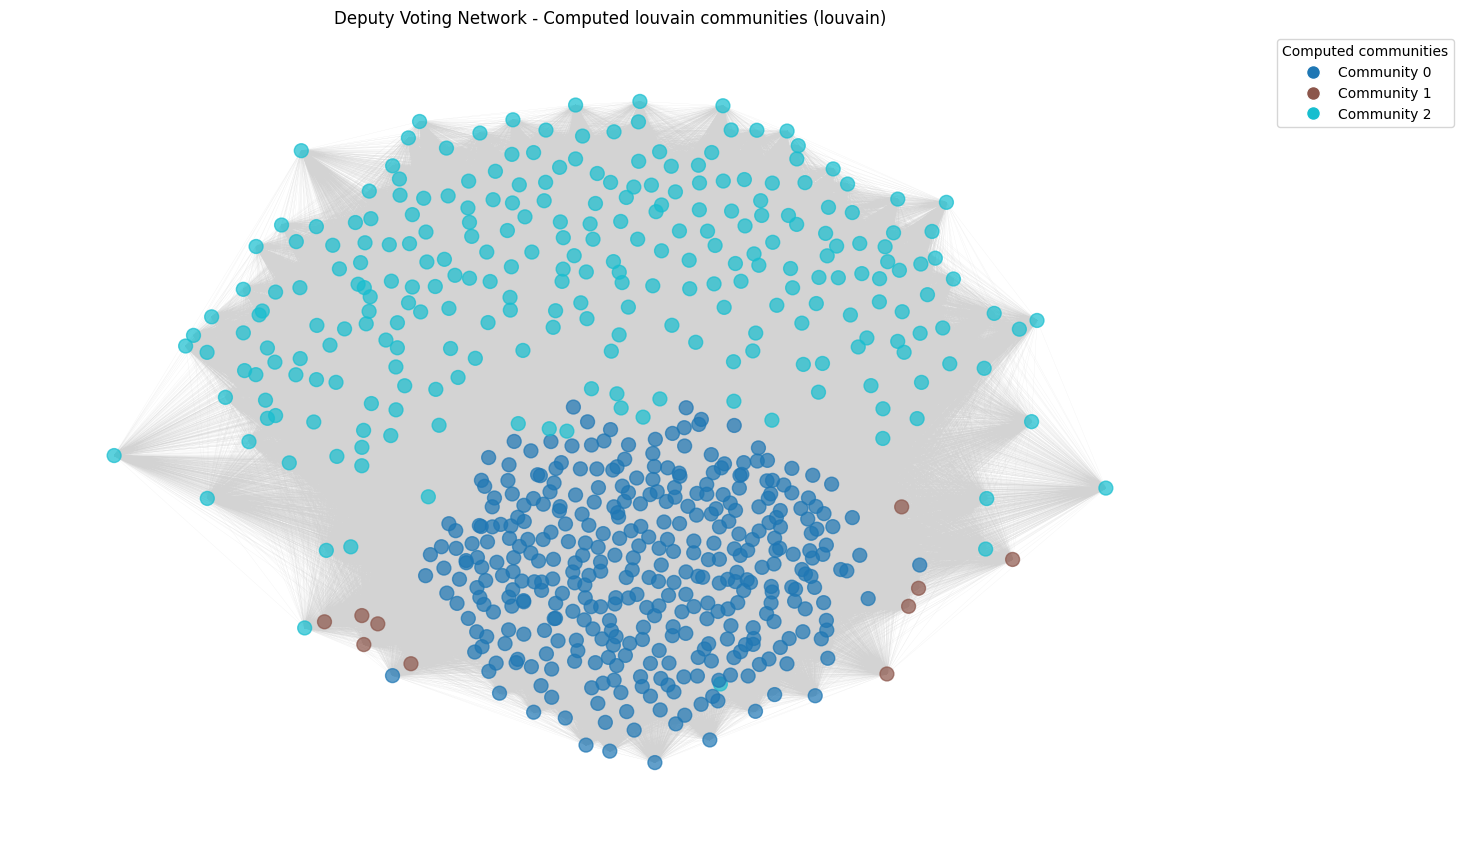

Number of communies : 3
Modularity score : 0.11212378480255555


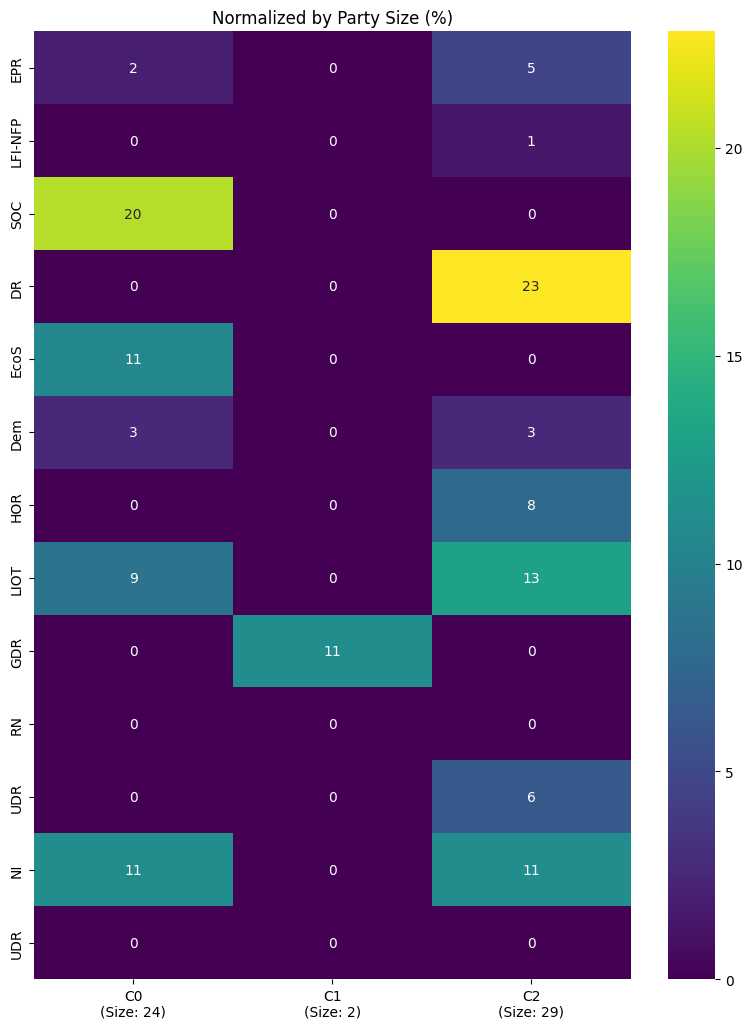

[{'PA1032',
  'PA1116',
  'PA1155',
  'PA1182',
  'PA1193',
  'PA1198',
  'PA1199',
  'PA1208',
  'PA1214',
  'PA1226',
  'PA1243',
  'PA1252',
  'PA1353',
  'PA1362',
  'PA1401',
  'PA1496',
  'PA1567',
  'PA1579',
  'PA1592',
  'PA1689',
  'PA1710',
  'PA1748',
  'PA1789',
  'PA1809',
  'PA1816',
  'PA1844',
  'PA1866',
  'PA1871',
  'PA1880',
  'PA1886',
  'PA1893',
  'PA1911',
  'PA1936',
  'PA1963',
  'PA1977',
  'PA1979',
  'PA1991',
  'PA2045',
  'PA2051',
  'PA2075',
  'PA2240',
  'PA2265',
  'PA2317',
  'PA2338',
  'PA2343',
  'PA2365',
  'PA2374',
  'PA2430',
  'PA2503',
  'PA2549',
  'PA2600',
  'PA2603',
  'PA2611',
  'PA2631',
  'PA266863',
  'PA267091',
  'PA267188',
  'PA267233',
  'PA267278',
  'PA267336',
  'PA267407',
  'PA267479',
  'PA267534',
  'PA267623',
  'PA267695',
  'PA267706',
  'PA267835',
  'PA267918',
  'PA267923',
  'PA267954',
  'PA267965',
  'PA268039',
  'PA268042',
  'PA268048',
  'PA2685',
  'PA2693',
  'PA271',
  'PA2713',
  'PA2799',
  'PA2800',
 

In [ ]:
communities_set, modularity_score = detect_communities(G_14)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

In [ ]:
G = create_graph(legislature_17["deputies"], legislature_17["votes"])
print_stats(G)
G_sample = get_giant_component(G)
plot_network(G_sample, legislature_17["deputies"])
plot_degree_distribution(G)
communities_set, modularity_score = detect_communities(G_sample)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))
proximites_partis = analyze_party_proximity(G_sample, partis_members, organ_name_dict, legislature_17["deputies"], True)
calculate_party_modularity(G_sample, partis_members)
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)

KeyboardInterrupt: 